In [33]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# from scipy.optimize import least_squares, minimize
# import jax.numpy.linalg as npl
# import jax.numpy as np
# from jax import grad, jit
import torch
from torch import nn


In [34]:
class MTL(nn.Module):
    def __init__(self,d,R,T):
        super(MTL, self).__init__()
        self.linear=nn.Linear(d,R,bias=False)
        self.heads=nn.ModuleList([nn.Linear(R,1,bias=False) for _ in range(T)])
    def forward(self, x, task_id):
        return self.heads[task_id](self.linear(x))

class CMTL(nn.Module):
    def __init__(self,d,r,K,T):
        super(CMTL, self).__init__()
        self.clusters=nn.ModuleList([nn.Linear(d,r,bias=False) for _ in range(K)])
        self.heads=nn.ModuleList([nn.Linear(r,1,bias=False) for _ in range(T)])
        self.PCID=None
    def forward(self, x, task_id):
        if self.PCID is None:
            raise ValueError('PCID is None')
        return self.heads[task_id](self.clusters[self.PCID[task_id]](x))

class MPMTL(nn.Module):
    def __init__(self,d,R,r,K,T):
        super(MPMTL, self).__init__()
        self.linear=nn.Linear(d,R,bias=False)
        self.clusters=nn.ModuleList([nn.Linear(R,r,bias=False) for _ in range(K)])
        self.heads=nn.ModuleList([nn.Linear(r,1,bias=False) for _ in range(T)])
        self.PCID=None
    def forward(self, x, task_id):
        if self.PCID is None:
            raise ValueError('PCID is None')
        return self.heads[task_id](self.clusters[self.PCID[task_id]](self.linear(x)))

In [38]:
def quant(x,c):
    return np.quantile(x,c,1)
def get_sub(r,d):
    return npl.svd(np.random.randn(r,d))[2][:r]
def randn_norm(T,r):
    X=np.random.randn(T,r)
    return np.array([X[i]/npl.norm(X[i]) for i in range(T)])

def eig_R(X,r):
    SH,V,_=npl.svd(X)
    return SH[:,:r].T,np.diag(V[:r])

def do_one_iter():
    T=K*k
    ERR=10000*np.ones((2,3))
    accuracy=[0,0]
    SM=get_sub(R,d)
    SC=[]
    SCC=[]
    for i in range(K):
        SC.append(get_sub(r,R))
        SCC.append(SC[i].dot(SM))

    betas=randn_norm(T,r)
    betah=torch.zeros((T,d,1))
    betasD=torch.zeros((T,d))
    yy=torch.zeros((T,n,1))
    XX=torch.randn(T,n,d)
    yt=torch.zeros((T,n,1))
    XT=torch.randn(T,n,d)
    corr=np.zeros((T))
    CID=np.array([i//k for i in range(T)])
    betaC=randn_norm(K,r)
    
    for i in range(K):
        while True:
            w=randn_norm(k,r)*(1-GAMMA)+betaC[i].reshape(1,-1)*GAMMA
            w/=npl.norm(w,axis=1).reshape(-1,1)
            score=np.sum(w.dot(w.T)**2-np.identity(k),axis=1)/(k-1)
            # print(score.min())
            if score.min()>THRED:
                # print(i,score.min())
                break
        for j, t in enumerate(np.where(CID==i)[0]):
            betas[t]=w[j]

    for t in range(T):
        betasD[t]=torch.from_numpy(np.asarray(SCC[CID[t]].T.dot(betas[t]))).float()
        yy[t]=XX[t].mm(betasD[t].reshape(-1,1))+torch.sqrt(torch.tensor(sigma))*torch.randn(n,1)
        yt[t]=XT[t].mm(betasD[t].reshape(-1,1))+torch.sqrt(torch.tensor(sigma))*torch.randn(n,1)
        betah[t]=XX[t].T.mm(yy[t])/n
        # corr[t]=betah[t].dot(betasD[t])/npl.norm(betah[t])
        
    Beta = betasD/torch.norm(betasD, dim=1).reshape(-1,1)
    PCID,acc=cluster_algo_v2(n_clusters=K, W=Beta.mm(Beta.T),CID=CID)
    print('oracle cluster acc', acc)
    accuracy[0]=acc
    # return Beta.mm(Beta.T)
    # Moment-based MTL, C-MTL, MP-MTL initializations
    MOM=np.zeros((d,d))
    MOMT=[]
    for i in range(K):
        MOMT.append(np.zeros((d,d)))
        for t in np.where(CID==i)[0]:
            MOM+=np.outer(betah[t],betah[t])
            MOMT[i]+=np.outer(betah[t],betah[t])
        MOMT[i]/=len(np.where(CID==i)[0])
    MOM/=T

    HM,_=eig_R(MOM,R)
    HC=[]
    errsubT=0
    for i in range(K):
        MOMH,_=eig_R(MOMT[i],r)
        errsubT+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SCC[i].T.dot(SCC[i]))
        HC.append(MOMH)

    MOMC=[]
    MOMCC=[]
    errsubP=0
    for i in range(K):
        MOMC.append(HM.T.dot(HM).dot(MOMT[i]).dot(HM.T.dot(HM)))

    HPC=[]
    for i in range(K):
        MOMH,_=eig_R(MOMC[i],r)
        errsubP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))
        HPC.append(MOMH)

    HP=[]
    errsubPP=0
    for i in range(K):
        HP.append(HPC[i].dot(HM.T))
        MOMH=HP[i].dot(HM)
        errsubPP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))


    # Alternating LS for MTL variations 
    GM=HM.copy()
    GT=np.array(HC)
    beta=np.zeros((T,d))
    betaC=np.zeros((T,r))
    Beta = torch.zeros((T,d))
    beta_=np.zeros((T,R))
    ITN=1000
    # MTL ALS
    if RANDOM_CLUSTER is True:
        PCID = CID
        np.random.shuffle(PCID)
        acc=1.
    elif GROUND_TRUTH is True:
        PCID = CID
        acc=1.
    else:
        print('Start MTL ...')
        model=MTL(d=d,R=R,T=T)
        criterion=nn.MSELoss()
        optimizer=torch.optim.SGD(model.parameters(),lr=lr_mtl)#torch.sqrt(torch.tensor(float(n))))
        model.linear.weight.data=torch.from_numpy(np.asarray(GM)).float()
        model.train()
        for it in range(ITN):
            loss=0.
            for t in range(T):
                output=model(XX[t],t)
                loss+=criterion(output,yy[t])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # def closure():
            #     loss=0.
            #     for t in range(T):
            #         output=model(XX[t],t)
            #         loss+=criterion(output,yy[t])
            #     optimizer.zero_grad()
            #     loss.backward()
            #     return loss
            # optimizer.step(closure)
            # loss=closure().item()
            if (it+1)%20 == 0:
                print(f'it {it+1}, training loss={loss/T}')
                # if it > 200:
                #     optimizer.param_groups[0]['lr']/=10
                # with torch.no_grad():
                #     u,D,vt=torch.svd(model.linear.weight)
                #     model.linear.weight.data=vt.T
                #     for t in range(T):
                #         model.heads[t].weight.data=model.heads[t].weight.data.mm(u).mm(torch.diag(D))
            if loss/T<eps:
                break

        model.eval()
        loss_train=0
        loss_test=0
        with torch.no_grad():
            for t in range(T):
                output=model(XX[t],t)
                loss_train+=criterion(output,yy[t])
                output=model(XT[t],t)
                loss_test+=criterion(output,yt[t])  
        ERR[0,0]=loss_train/T
        ERR[1,0]=loss_test/T
        print(ERR[0,0],ERR[1,0])

        # Beta = betasD/npl.norm(betasD, axis=1).reshape(-1,1)
        # Beta = (beta/npl.norm(beta,axis=1).reshape(-1,1)).copy()
        for t in range(T):
            bt=model.linear.weight.data.T.mm(model.heads[t].weight.data.T).reshape(-1)
            Beta[t]=bt/torch.norm(bt)
        PCID,acc=cluster_algo_v2(n_clusters=K, W=Beta.mm(Beta.T), CID=CID)
        print('cluster acc', acc)
        accuracy[1]=acc
        
        # print('PCID', PCID)
        # print('CID',CID)
        # print(np.abs(Beta.dot(Beta.T)))
    # ITN=0
    # C-MTL ALS
    print('Start CMTL ...')
    model=CMTL(d=d,r=r,K=K,T=T)
    model.PCID=PCID
    criterion=nn.MSELoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=lr_cmtl*acc)
    for i in range(K):
        model.clusters[i].weight.data=torch.from_numpy(np.asarray(GT[i])).float()
    model.train()
    for it in range(ITN):
        loss=0.
        for t in range(T):
            output=model(XX[t],t)
            loss+=criterion(output,yy[t])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (it+1)%20 == 0:
            print(f'it {it+1}, training loss={loss/T}')
            ## 
            # with torch.no_grad():
            #     for i in range(K):
            #         u_,D_,vt_=torch.svd(model.clusters[i].weight.data)
            #         model.clusters[i].weight.data=vt_.T
            #         for t in np.where(PCID==i)[0]:
            #             model.heads[t].weight.data=model.heads[t].weight.data.mm(u_).mm(torch.diag(D_))
            ##
        if loss/T<eps:
            break
    model.eval()
    loss_train=0
    loss_test=0
    with torch.no_grad():
        for t in range(T):
            output=model(XX[t],t)
            loss_train+=criterion(output,yy[t])
            output=model(XT[t],t)
            loss_test+=criterion(output,yt[t])  
    ERR[0,1]=loss_train/T
    ERR[1,1]=loss_test/T
    print(ERR[0,1],ERR[1,1])

    
    # ITN=600
    # MP-MTL ALS
    print('Start MP-MTL ...')
    GP=np.array(HP)
    GPM=HM.copy()
    model=MPMTL(d=d,R=R,r=r,K=K,T=T)
    model.PCID=PCID
    criterion=nn.MSELoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=lr_mpmtl*acc)
    model.linear.weight.data=torch.from_numpy(np.asarray(GPM)).float()
    for i in range(K):
        model.clusters[i].weight.data=torch.from_numpy(np.asarray(GP[i])).float()
    model.train()
    for it in range(ITN):
        loss=0.
        for t in range(T):
            output=model(XX[t],t)
            loss+=criterion(output,yy[t])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (it+1)%20 == 0:
            print(f'it {it+1}, training loss={loss/T}')
            # if it > 100:
                # optimizer.param_groups[0]['lr']/=10
            with torch.no_grad():
                u,D,vt=torch.svd(model.linear.weight.data)
                model.linear.weight.data=vt.T
                for i in range(K):
                    model.clusters[i].weight.data= model.clusters[i].weight.data.mm(u).mm(torch.diag(D))
                    u_,D_,vt_=torch.svd(model.clusters[i].weight.data)
                    model.clusters[i].weight.data=vt_.T
                    for t in np.where(model.PCID==i)[0]:
                        model.heads[t].weight.data=model.heads[t].weight.data.mm(u_).mm(torch.diag(D_))
        if loss/T<eps:
            break
    model.eval()
    loss_train=0
    loss_test=0
    with torch.no_grad():
        for t in range(T):
            output=model(XX[t],t)
            loss_train+=criterion(output,yy[t])
            output=model(XT[t],t)
            loss_test+=criterion(output,yt[t])  
    ERR[0,2]=loss_train/T
    ERR[1,2]=loss_test/T
    print(ERR[0,2],ERR[1,2])
    return ERR, acc

In [39]:
lr_mtl=2e-2
sigma=0.
eps=0.
ITN=1 # NUMBER OF AVERAGES TO RUN
r=2
R=32
d=128
# n0=10
# nb=int(np.sqrt(R*r)*n0)
# kb=10
nb=40
Kb=64
kb=10
# T=Kb*k
LEN=4
ns=(np.arange(LEN)+1)*20
# ns=[40,50,60]
ks=[2,4,7,10,15,20]
# Ks=[5,10,20,30,40,60,80,110,150]
# ns=[100,10]
# lrs=[0.001,0.0005]
# LEN=len(ks)
# Ks=[2,50]
# model_mtl=MTL(d=d,R=R,T=T)
# model_cmtl=CMTL(d=d,r=r,K=K,T=T)
# model_mpmtl=MPMTL(d=d,R=R,r=r,K=K,T=T)
ERRn=np.zeros((LEN,ITN,3,2,3))
ERRk=np.zeros((LEN,ITN,3,2,3))
ERRK=np.zeros((LEN,ITN,3,2,3))
acc=np.zeros((LEN,ITN,2))
print('Vary # samples')
for it in range(ITN):
    for x in range(LEN):
        n=ns[x]; k=kb; K=Kb
        print(n,k,K)
        RANDOM_CLUSTER=False
        GROUND_TRUTH = False
        ERRn[x,it,0],acc[x,it]=do_one_iter()
        # GROUND_TRUTH = True
        # ERRn[x,it,1],_=do_one_iter()
        # RANDOM_CLUSTER = True
        # ERRn[x,it,2]=do_one_iter()
    # np.save(f'clustering_error_pytorch_n_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}.npy',ERRn)

# print('Vary # tasks')
# for x in range(LEN):
#     n=nb; k=ks[x]; K=Kb
#     print(n,k,K)
#     for it in range(ITN):
#         RANDOM_CLUSTER=False
#         GROUND_TRUTH = False
#         ERRk[x,it,0]=do_one_iter()
#         GROUND_TRUTH = True
#         ERRk[x,it,1]=do_one_iter()
#         RANDOM_CLUSTER = True
#         ERRk[x,it,2]=do_one_iter()

# print('Vary # of clusters')
# for x in range(LEN):
#     n=nb; T=T; K=Ks[x]
#     print(n,T,K)
#     for it in range(ITN):
#         GROUND_TRUTH = False
#         ERRK[x,it,0]=do_one_iter()
#         GROUND_TRUTH = True
#         ERRK[x,it,1]=do_one_iter()
# np.save('cluster_error_K.npy',ERRK)
# np.save('cluster_error_kk.npy',ERRk)
# np.save(f'clustering_error_pytorch_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}sigma{sigma}.npy',ERRn)
# np.save(f'clustering_error_k_R{R}r{r}d{d}K{Kb}n{nb}ITN{ITN}THRED{THRED}.npy',ERRk)

Vary # samples
20 10 40
oracle cluster acc 1.0
Start MTL ...
it 20, training loss=0.06764359772205353
it 40, training loss=0.016914915293455124
it 60, training loss=0.006199896801263094
it 80, training loss=0.002666685963049531
it 100, training loss=0.0012605005176737905
it 120, training loss=0.0006369886687025428
it 140, training loss=0.0003386514144949615
it 160, training loss=0.00018728179566096514
it 180, training loss=0.00010683330765459687
9.578789467923343e-05 1.3705471754074097
cluster acc 0.06
Start CMTL ...
it 20, training loss=0.8423950672149658
it 40, training loss=0.6893420219421387
it 60, training loss=0.6094958782196045
it 80, training loss=0.5562680959701538
it 100, training loss=0.5164889693260193
it 120, training loss=0.4849180579185486
it 140, training loss=0.4589380919933319
it 160, training loss=0.43707457184791565
it 180, training loss=0.41840851306915283
it 200, training loss=0.4022955000400543
it 220, training loss=0.38825875520706177
it 240, training loss=0.375

In [40]:
# sigma=0.
# np.save(f'clustering_error_v2_pytorch_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}sigma{sigma}.npy',ERRn)
# ITN=1
# LEN=5
# IDX=1
# THRED=0.5
# r=2;R=32;d=128;k=10;Kb=64
# ns=(np.arange(LEN)+1)*20
# sigma=0.02
# # ERRn=np.load(f'clustering_error_fixed_n_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}.npy')
# # ERRn=np.load(f'clustering_error_fixed_n_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}sigma{sigma}.npy')
# # print(ns, ERRn.shape)
# # ns=ns[:,:IDX]
# # ERRn = ERRn[:,:IDX]
# print(ERRn)
# sigma=0.02
# ERRn=np.load(f'clustering_error_v2_pytorch_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}sigma{sigma}.npy')

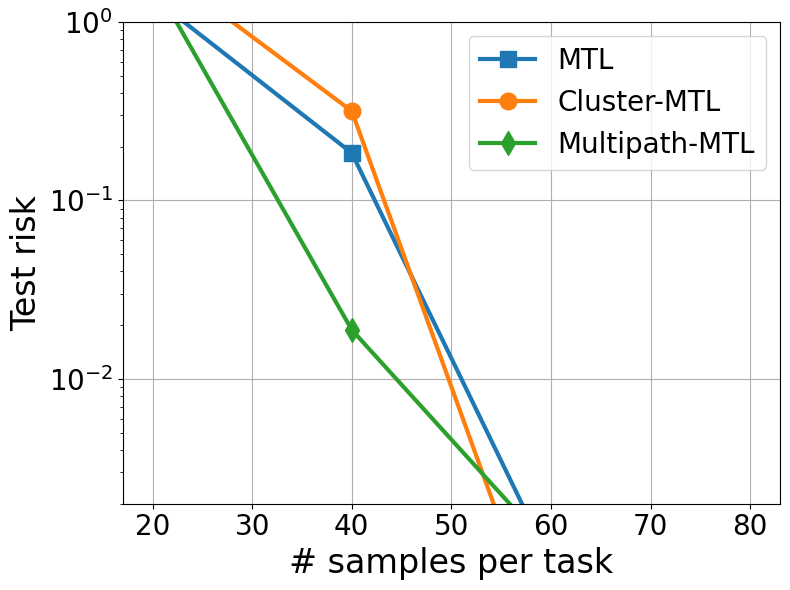

In [41]:
mrk=['s','o','d']
labels=['MTL','Cluster-MTL','Multipath-MTL']
labels2=['Oracle','Random']
ls=[]
plt.figure(figsize=(8,6))
ax = plt.gca()
# ns = ns[:10]
for i in range(3):
    color = next(ax._get_lines.prop_cycler)['color']
    l,=plt.semilogy(ns,quant(ERRn[:,:,0,1,i],0.5),'-'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
    ls.append(l)
    # plt.semilogy(ns,quant(ERRn[:,:,0,0,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
    if i >0:
        s1,=plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
        s2,=plt.semilogy(ns,quant(ERRn[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
    # if i == 2:
    #     s1=plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
    #     plt.semilogy(ns,quant(ERRn[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
    plt.fill_between(ns,quant(ERRn[:,:,0,1,i],0.25),quant(ERRn[:,:,0,1,i],0.75),alpha=0.25)
plt.ylim([0.002,1])
# plt.xlim([0,20])
# plt.legend(['MTL','Cluster-MTL','Multipath-MTL'],fontsize=20)
legend1=plt.legend([s1,s2],labels2,fontsize=20,loc='center left')
plt.legend(ls,labels,fontsize=20)
# plt.gca().add_artist(legend1)
# plt.legend(labels2,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('# samples per task',fontsize=24)
plt.ylabel('Test risk',fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('clusterring_sample_per_task_pinv.pdf')

# plt.figure(figsize=(8,6))
# ax = plt.gca()
# for i in range(3):
#     color = next(ax._get_lines.prop_cycler)['color']
#     l,=plt.semilogy(ks,quant(ERRk[:,:,0,1,i],0.5),'-'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
#     ls.append(l)
#     # plt.semilogy(ns,quant(ERRn[:,:,0,0,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
#     if i >0:
#         s1,=plt.semilogy(ks,quant(ERRk[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
#         s2,=plt.semilogy(ks,quant(ERRk[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
#     # if i == 2:
#     #     s1=plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
#     #     plt.semilogy(ns,quant(ERRn[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
#     plt.fill_between(ks,quant(ERRk[:,:,0,1,i],0.25),quant(ERRk[:,:,0,1,i],0.75),alpha=0.25)
# # plt.ylim([0.002,1])
# # plt.xlim([0,50])
# # plt.legend(['MTL','Cluster-MTL','Multipath-MTL'],fontsize=20)
# # plt.legend(fontsize=20)
# legend1=plt.legend([s1,s2],labels2,fontsize=20,loc='center left')
# plt.legend(ls,labels,fontsize=20)
# plt.gca().add_artist(legend1)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel('# tasks per cluster',fontsize=24)
# plt.ylabel('Test risk',fontsize=24)
# plt.grid(True)
# plt.tight_layout()
# # plt.show()
# plt.savefig(f'clustering_task_per_cluster_{ITN}runs.pdf')

# plt.figure(figsize=(8,6))
# ax = plt.gca()
# for i in range(3):
#     color = next(ax._get_lines.prop_cycler)['color']
#     q=quant(ERRK[:,:,0,1,i],0.5); q2=q.copy()
#     q_=quant(ERRK[:,:,1,1,i],0.5); q2_=q_.copy()
#     #if i==1: q2[:1]=np.array([0.192])
#     plt.semilogy(Ks,q2,mrk[i]+'-',linewidth=4,markersize=12,color=color,label=labels[i])
#     plt.semilogy(Ks,q2_,mrk[i]+'--',linewidth=4,markersize=12,color=color)
#     plt.fill_between(Ks,quant(ERRK[:,:,0,1,i],0.25)+q2-q,quant(ERRK[:,:,0,1,i],0.75)+q2-q,alpha=0.25)
# # plt.ylim([0.002,1])
# # plt.xlim([0,150])
# # plt.legend(['MTL','Cluster-MTL','Multipath-MTL'],fontsize=20)
# plt.legend(fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel('# clusters',fontsize=24)
# plt.ylabel('Test risk',fontsize=24)
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# # plt.savefig('cluster_fig.pdf')